In [1]:
%matplotlib inline
import numpy as np
from scipy import signal
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Test Signal Generation

Before we can build/test the receiver, we first need to build up the means to generate test signals. Let's first get started by setting some basic parameters.

In [2]:
# High level parameters
sample_rate = 5e9 # 5Ghz
symbol_rate = 1e6 # 1Mhz
samples_per_symbol = int(sample_rate/symbol_rate)

Because we're simulating Bluetooth which uses Gaussian Minimum Shift Keying, we need a gaussian kernel to convolve with the bits

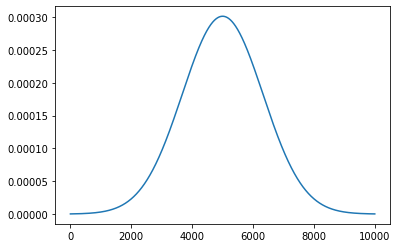

In [3]:
BT = 0.5
bw = symbol_rate*BT/sample_rate

# This looks scary but it's just a traditional gaussian distribution from wikipedia
kernel = np.array([(np.sqrt(2*np.pi/np.log(2))*bw)*np.exp(-(2/np.log(2))*np.power(np.pi*t*bw, 2)) for t in range(-5000,5000)])
kernel /= sum(kernel) # Normalize so things amplitude after convolution remains the same
plt.plot(kernel)

Next let's make a quick function to generate random bits. This is traditionally done with linear feedback shift registers, which can be used to generate pseudorandom bit sequences.

In [4]:
def prbs(n=0, taps=[]):
    state = [1]*n
    shift = lambda s: [sum([s[i] for i in taps]) % 2] + s[0:-1]
    out = []
    for i in range(2**n - 1):
        out.append(state[-1])
        state = shift(state)
    return out
prbs9 = lambda: prbs(n=9, taps=[4,8])
len(prbs9())

511

Let's now simulate GMSK. One way to think about GMSK is that the current bit defines whether the phase is increasing or decreasing at a specific rate. Let that rate be 1, so for 0 bits, the rate is -1.

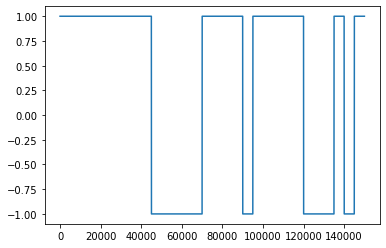

In [5]:
rotation = np.repeat(prbs9()[:30], sample_rate/symbol_rate)*2.0 - 1.0
plt.plot(rotation)

Now let's smooth it out using the guassian kernel above (this helps reduce the required bandwidth because bit transitions aren't as abrupt)

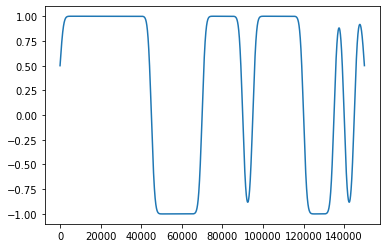

In [6]:
smoothed_rotation = np.convolve(rotation, kernel,mode='same')
plt.plot(smoothed_rotation)

Now let's take these rotation rates and compound them into an actual phase angle for a given point in time

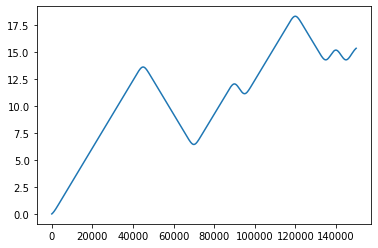

In [7]:
angle_per_sample = (np.pi/2.0)/(samples_per_symbol)
current_angle = 0

# This actually stores the angle as point on the complex unit circle
modulated = np.zeros((len(smoothed_rotation),), dtype=np.complex64) # Represents I and Q as a complex number

i = 0
for bit in smoothed_rotation:
  current_angle += angle_per_sample*bit
  modulated[i] = np.exp(1j*current_angle)
  i += 1

# Unwrap is a handle function to unroll when an angle crosses from 2*pi to 0.
plt.plot(np.unwrap(np.angle(modulated)))

Next we need to take this baseband signal and modulate it up to the carrier. Let's say BLE channel 37 which is at 2.402Ghz

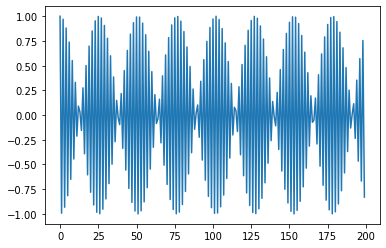

In [8]:
carrier_freq = 2.402e9

def make_carrier(freq=None, sample_rate=None, samples=None, phase=0):
  t = (1/sample_rate)*np.arange(samples)
  return np.real(np.exp(1j*(2*np.pi*freq*t - phase)))

I = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=0)
Q = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=np.pi/2)

upconverted = np.real(modulated)*I + np.imag(modulated)*Q

# This is just a tiny fraction of the full signal, because it's so high frequency, if we plot the 
# whole thing we get a block of blue
plt.plot(upconverted[:200])

Now let's combine this all together into a handy function that takes bits and outputs a modulated signal

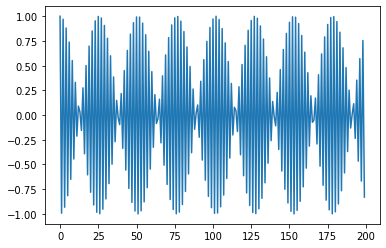

In [9]:
def modulate_gmsk(bits, carrier_freq=2.402e9):
    rotation = np.repeat(bits, sample_rate/symbol_rate)*2.0 - 1.0
    smoothed_rotation = np.convolve(rotation, kernel,mode='same')

    angle_per_sample = (np.pi/2.0)/(samples_per_symbol)
    current_angle = 0
    modulated = np.zeros((len(smoothed_rotation),), dtype=np.complex64) # Represents I and Q as a complex number
    i = 0
    for bit in smoothed_rotation:
      current_angle += angle_per_sample*bit
      modulated[i] = np.exp(1j*current_angle)
      i += 1

    I = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=0)
    Q = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=np.pi/2)

    return np.real(modulated)*I + np.imag(modulated)*Q

plt.plot(modulate_gmsk(prbs9()[:30])[:200])

# Ideal Demodulator
Now let's such an ideal demodulator that uses traditional methods (described in comments) as a reference

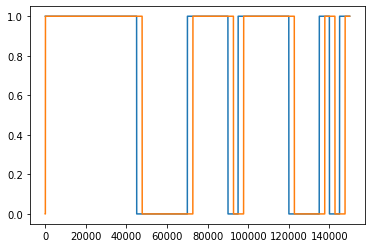

In [10]:
def demodulate_gmsk(sig):
    I = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(sig), phase=0)
    Q = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(sig), phase=np.pi/2)

    # Mix down to (complex) baseband
    down = sig*I + 1j*sig*Q

    # Create a low pass filter at the symbol rate
    sos = signal.butter(5, symbol_rate, 'low', fs=sample_rate, output='sos')
    filtered_down = signal.sosfilt(sos, down)

    # Take the phase angle of the baseband
    angle = np.unwrap(np.angle(filtered_down))

    # Take the derivative of the phase angle and hard limit it to 1:-1
    return (np.sign(angle[1:] - angle[:-1]) + 1.0)/2.0

# Generate sample bits and plot them
sample = prbs9()[:30]
plt.plot(np.repeat(sample, sample_rate/symbol_rate))
    
# Plot the recovered bits. Note that because of the filtering the data is shifted some number of samples
plt.plot(demodulate_gmsk(modulate_gmsk(sample)))

# Channel Simulation
In order to measure the performance of the demodulator in the presence of noise, we need to generate some noise!

Note that I didn't do any channel simulation when developing my first prototype. Only after I got something working did I set this up so that I could objectively compare different approaches.

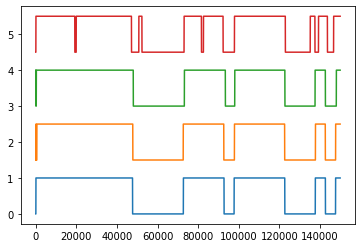

In [11]:
def add_noise(sig, power=0.1):
    noise = np.sqrt(power)*(np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))/np.sqrt(2)
    return sig + noise

# Create a signal with a power of 1
modulated = np.sqrt(2)*modulate_gmsk(sample)

# Try to demodulate at various different power levels
plt.plot(demodulate_gmsk(add_noise(modulated, power=0.1)))
plt.plot(demodulate_gmsk(add_noise(modulated, power=1)) + 1.5)
plt.plot(demodulate_gmsk(add_noise(modulated, power=10)) + 3)
plt.plot(demodulate_gmsk(add_noise(modulated, power=100)) + 4.5)

Next, we need a quick and dirty way to sample symbols from the demodulated bits. Let's do the very simple thing of taking whatever value is demodulated at the center of the bit accounting for the delay caused by the low pass filter (observationally derived in this case due to laziness)

In [12]:
def extract_bits(sig):
    return sig[int(1.5*samples_per_symbol//2)::samples_per_symbol]

sample = prbs9()[:30]
np.array_equal(sample, extract_bits(demodulate_gmsk(modulated)))

True

In [13]:
def evaluate_bit_error_rate(bits, sig, demod_func):
    power = np.var(sig)
    normalized = sig*np.sqrt(1.0/power)
    levels = np.logspace(-1, 4, num=10)
    errors = []
    bits = np.array(bits).astype(np.uint8)
    for level in levels:
        demod_bits = extract_bits(demod_func(add_noise(normalized, power=level)))
        error_count = sum(demod_bits.astype(np.uint8) ^ bits)
        errors.append(error_count)
    return 10*np.log(1/levels)/np.log(10), np.array(errors)/len(bits)

In [14]:
sample = np.tile(prbs9(),2)
ideal_levels, ideal_errors = evaluate_bit_error_rate(sample, modulate_gmsk(sample), demodulate_gmsk)

Now, if we plot this, we get a bit error rate that goes to zero around -13db SNR (which was surprising to me)

Text(0, 0.5, 'Bit Error Rate')

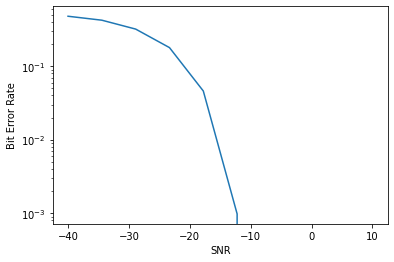

In [16]:
plt.plot(ideal_levels, ideal_errors)
plt.yscale('log')
plt.xlabel("SNR")
plt.ylabel("Bit Error Rate")

# 1-bit quantized demodulator
Now, let's simulate a demodulator that only has one bit of precision and see how it performs. Note that this assumes full-precision processing, which won't be the case in our implementation.

In [17]:
def demodulate_gmsk_1bit(sig):
    return demodulate_gmsk(np.sign(sig))

sample = np.tile(prbs9(),2)
one_bit_levels, one_bit_errors = evaluate_bit_error_rate(sample, modulate_gmsk(sample), demodulate_gmsk)

If we plot this we see a marginal decrease in performance, but nothing too significant.

Text(0, 0.5, 'Bit Error Rate')

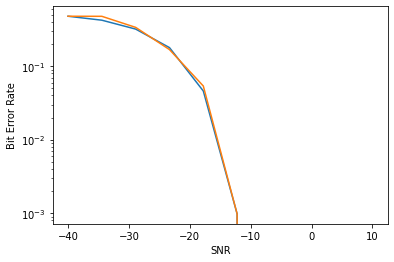

In [18]:
plt.plot(ideal_levels, ideal_errors)
plt.plot(one_bit_levels, one_bit_errors)
plt.yscale('log')
plt.xlabel("SNR")
plt.ylabel("Bit Error Rate")

# 1-bit quantized nmigen demodulator

Now we'll test a purely nmigen implementation of the demodulator, using pieces from the `alldigitalradio` package.

This is conceptually equivalent to the FPGA version, but for simplicity we only use once clock domain. On real hardware we subsample out of the Summing Mixer which means the running boxcar filter is only 64 samples long rather than the 256 used here.

In [19]:
from alldigitalradio.mixer import SummingMixer
from alldigitalradio.util import pack_mem
from alldigitalradio.filter import RunningBoxcarFilter
from alldigitalradio.trig import MagnitudeApproximator
from alldigitalradio.io.numpy import make_callable, take_n

from nmigen import Module, Signal, signed

m = Module()

rfdata = Signal(20)

# Create the mixers and attach the rfdata to it
m.submodules.mixerHigh = mixerHigh = SummingMixer(sample_rate=5e9, frequency=2.40225e9, max_error=0.0001)
m.submodules.mixerLow = mixerLow = SummingMixer(sample_rate=5e9, frequency=2.40175e9, max_error=0.0001)
m.d.comb += [
    mixerHigh.input.eq(rfdata),
    mixerLow.input.eq(rfdata)
]

# Now do construct pass filters on the outputs
width = 256
m.submodules.lpfHighI = lpfHighI = RunningBoxcarFilter(width)
m.submodules.lpfHighQ = lpfHighQ = RunningBoxcarFilter(width)
m.submodules.lpfLowI = lpfLowI = RunningBoxcarFilter(width)
m.submodules.lpfLowQ = lpfLowQ = RunningBoxcarFilter(width)
m.d.comb += [
    lpfHighI.input.eq(mixerHigh.outputIsum),
    lpfHighQ.input.eq(mixerHigh.outputQsum),
    lpfLowI.input.eq(mixerLow.outputIsum),
    lpfLowQ.input.eq(mixerLow.outputQsum),
]

# Next compute the magnitude of the low-pass-filtered I and Q
m.submodules.highMag = highMag = MagnitudeApproximator()
m.submodules.lowMag = lowMag = MagnitudeApproximator()
m.d.comb += [
    highMag.inputI.eq(lpfHighI.output),
    highMag.inputI.eq(lpfHighQ.output),
    lowMag.inputI.eq(lpfLowI.output),
    lowMag.inputQ.eq(lpfLowQ.output),
]

# Finally, compare the two magnitudes
baseband = Signal(signed(32))
m.d.comb += baseband.eq(lowMag.magnitude > highMag.magnitude)

demodulator = make_callable(m, startup_cycles=4, inputs=[rfdata], outputs=[baseband])

Goal Frequency: 2402250000.0, actual: 2402250000.0, period: 20000, len: 1000
Goal Frequency: 2402250000.0, actual: 2402250000.0, period: 20000, len: 1000
Goal Frequency: 2401750000.0, actual: 2401750000.0, period: 20000, len: 1000
Goal Frequency: 2401750000.0, actual: 2401750000.0, period: 20000, len: 1000


Let's set up some sample data again to test against

In [20]:
# Generate sample bits and modulate them
sample = prbs9()[:30]
modulated = pack_mem(np.sign(modulate_gmsk(sample)), width=20)

Run the actual simulation

In [21]:
# Demodulate using the hardware implementation
demodulated = list(map(demodulator, modulated))

Let's see how we did!

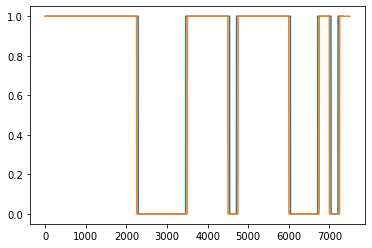

In [22]:
# Factor out the delay that it takes for things to make it through the system
plt.plot(demodulated[160:])
# Plot the reference input signal
plt.plot(np.repeat(sample, sample_rate/(20*symbol_rate)))

As you can see, the bits are there, although there's some error introduced by what I'm assuming is imprecision in the magnitude approximation that makes the zero bits a bit "thinner" than one would otherwise expect.

Now let's measure the bit error rate! **(Warning: this is slooooow -- like half an hour slow. I've used verilator in the past but haven't integrated it as conveniently into Python notebooks as the default nmigen simulator with `make_callable`)**

In [23]:
def demodulate_gmsk_nmigen(sig):
    demodulator = make_callable(m, startup_cycles=4, inputs=[rfdata], outputs=[baseband])
    out = list(map(demodulator, pack_mem(np.sign(sig), width=20)))[160:] + [0]*160
    return np.repeat(out, 20)

sample = np.tile(prbs9(),2)
nmigen_levels, nmigen_errors = evaluate_bit_error_rate(sample, modulate_gmsk(sample), demodulate_gmsk_nmigen)

Text(0, 0.5, 'Bit Error Rate')

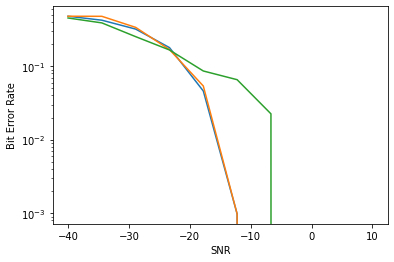

In [24]:
plt.plot(ideal_levels, ideal_errors)
plt.plot(one_bit_levels, one_bit_errors)
plt.plot(nmigen_levels, nmigen_errors)
plt.yscale('log')
plt.xlabel("SNR")
plt.ylabel("Bit Error Rate")

Somewhat unsurprisingly, the nmigen implementation is a decent amount worse, although it uses a different demodulation scheme than in the one-bit demodulation.

To determine if this is due to some sort of loss in precision or just the approach is worse, let's build it in numpy and evaluate it.

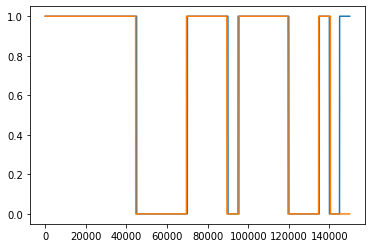

In [25]:
def demodulate_gmsk_nophase(sig):
    lowI = np.sign(make_carrier(freq=2.40225e9, sample_rate=sample_rate, samples=len(sig), phase=0))
    lowQ = np.sign(make_carrier(freq=2.40225e9, sample_rate=sample_rate, samples=len(sig), phase=np.pi/2))

    highI = np.sign(make_carrier(freq=2.40175e9, sample_rate=sample_rate, samples=len(sig), phase=0))
    highQ = np.sign(make_carrier(freq=2.40175e9, sample_rate=sample_rate, samples=len(sig), phase=np.pi/2))
    
    # Mix down to (complex) baseband
    low_downI = sig*lowI
    low_downQ = sig*lowQ
    high_downI = sig*highI
    high_downQ = sig*highQ

    # Create a low pass filter at the symbol rate
    sos = signal.butter(5, symbol_rate*0.5, 'low', fs=sample_rate, output='sos')
    filtered_low_downI = signal.sosfilt(sos, low_downI)
    filtered_low_downQ = signal.sosfilt(sos, low_downQ)
    filtered_high_downI = signal.sosfilt(sos, high_downI)
    filtered_high_downQ = signal.sosfilt(sos, high_downQ)
    
    # Take the phase angle of the baseband
    #return np.abs(filtered_high_downI + 1j*filtered_high_downQ)
    result = np.sign(np.abs(filtered_high_downI - 1j*filtered_high_downQ) - np.abs(filtered_low_downI + 1j*filtered_low_downQ))*0.5 + 0.5
    return np.concatenate((result[5000:], [0]*5000))

sample = prbs9()[:30]
plt.plot(np.repeat(sample, int(sample_rate/symbol_rate)))
plt.plot(demodulate_gmsk_nophase(modulate_gmsk(sample)))

In [26]:
sample = np.tile(prbs9(),2)
nophase_levels, nophase_errors = evaluate_bit_error_rate(sample, modulate_gmsk(sample), demodulate_gmsk_nophase)

Now let's compare everything all together

Text(0, 0.5, 'Bit Error Rate')

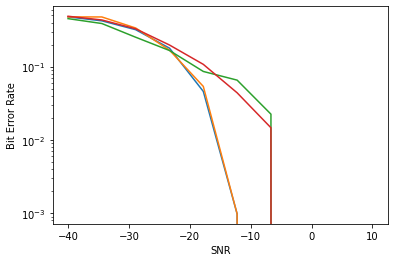

In [27]:
plt.plot(ideal_levels, ideal_errors)
plt.plot(one_bit_levels, one_bit_errors)
plt.plot(nmigen_levels, nmigen_errors)
plt.plot(nophase_levels, nophase_errors)
plt.yscale('log')
plt.xlabel("SNR")
plt.ylabel("Bit Error Rate")

Seems like we should build CORDIC and use a traditional method!